In [47]:
import matplotlib.pyplot as plt
import numpy as np
import flet as ft
import os
from pylsl import StreamInlet, resolve_stream
from scipy.signal import welch, spectrogram
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, accuracy_score
import pandas as pd
from joblib import dump, load
import pyxdf
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
import seaborn as sns
from keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import StandardScaler

In [48]:
# Combine all data stored in the same folder to use for training the model.
def concat_data(frequency):
    data_folder = f'../../../../data_ssvep/Toey/flicker1/{frequency}'
    all_data = []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        streams, _ = pyxdf.load_xdf(file_path)
        raw_data = streams[0]["time_series"].T
        all_data.append(raw_data)
    all_data_array = np.concatenate(all_data, axis=1)
    return all_data_array


In [49]:
def create_overlapping_sets(data, set_size=500, overlap_fraction=0.5):
    step = int(set_size * (1 - overlap_fraction))
    sets = []
    for i in range(0, len(data) - set_size + 1, step):
        sets.append(data[i:i + set_size])
    return sets

In [50]:
raw_test1 = concat_data('6Hz')
print(raw_test1[0:4,:].shape)
raw_test2 = concat_data('20Hz')
print(raw_test2[0:4,:].shape)
raw_test3 = concat_data('0Hz')
print(raw_test3[0:4,:].shape)

(4, 164640)
(4, 166330)
(4, 167630)


In [51]:
set_size=1000
overlap_fraction=0.5
data_test1 = raw_test1[0:4,:]
data_test1_oz = data_test1[0] - data_test1[1]
data_test1_o1 = data_test1[2] - data_test1[1]
data_test1_o2 = data_test1[3] - data_test1[1]
data_test1_set_oz = create_overlapping_sets(data_test1_oz, set_size=set_size, overlap_fraction=overlap_fraction)
data_test1_set_o1 = create_overlapping_sets(data_test1_o1, set_size=set_size, overlap_fraction=overlap_fraction)
data_test1_set_o2 = create_overlapping_sets(data_test1_o2, set_size=set_size, overlap_fraction=overlap_fraction)
data_test1_fft_oz = []
data_test1_fft_o2 = []
data_test1_fft_o1 = []
for i in range(len(data_test1_set_oz)):
    f, Pxx = welch(data_test1_set_oz[i], fs=250, nperseg= 250*4)
    data_test1_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data_test1_set_o1[i], fs=250, nperseg= 250*4)
    data_test1_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data_test1_set_o2[i], fs=250, nperseg= 250*4)
    data_test1_fft_o2.append(Pxx[0:121])

combined_test1 = np.hstack((data_test1_fft_oz, data_test1_fft_o1, data_test1_fft_o2))
data_test2 = raw_test2[0:4,:]
data_test2_oz = data_test2[0] - data_test2[1]
data_test2_o1 = data_test2[2] - data_test2[1]
data_test2_o2 = data_test2[3] - data_test2[1]
data_test2_set_oz = create_overlapping_sets(data_test2_oz, set_size=set_size, overlap_fraction=overlap_fraction)
data_test2_set_o1 = create_overlapping_sets(data_test2_o1, set_size=set_size, overlap_fraction=overlap_fraction)
data_test2_set_o2 = create_overlapping_sets(data_test2_o2, set_size=set_size, overlap_fraction=overlap_fraction)
data_test2_fft_oz = []
data_test2_fft_o2 = []
data_test2_fft_o1 = []
for i in range(len(data_test2_set_oz)):
    f, Pxx = welch(data_test2_set_oz[i], fs=250, nperseg= 250*4)
    data_test2_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data_test2_set_o1[i], fs=250, nperseg= 250*4)
    data_test2_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data_test2_set_o2[i], fs=250, nperseg= 250*4)
    data_test2_fft_o2.append(Pxx[0:121])

combined_test2 = np.hstack((data_test2_fft_oz, data_test2_fft_o1, data_test2_fft_o2))

data_test3 = raw_test3[0:4,:]
data_test3_oz = data_test3[0] - data_test3[1]
data_test3_o1 = data_test3[2] - data_test3[1]
data_test3_o2 = data_test3[3] - data_test3[1]
data_test3_set_oz = create_overlapping_sets(data_test3_oz, set_size=set_size, overlap_fraction=overlap_fraction)
data_test3_set_o1 = create_overlapping_sets(data_test3_o1, set_size=set_size, overlap_fraction=overlap_fraction)
data_test3_set_o2 = create_overlapping_sets(data_test3_o2, set_size=set_size, overlap_fraction=overlap_fraction)
data_test3_fft_oz = []
data_test3_fft_o2 = []
data_test3_fft_o1 = []
for i in range(len(data_test3_set_oz)):
    f, Pxx = welch(data_test3_set_oz[i], fs=250, nperseg= 250*4)
    data_test3_fft_oz.append(Pxx[0:121])

    f, Pxx = welch(data_test3_set_o1[i], fs=250, nperseg= 250*4)
    data_test3_fft_o1.append(Pxx[0:121])

    f, Pxx = welch(data_test3_set_o2[i], fs=250, nperseg= 250*4)
    data_test3_fft_o2.append(Pxx[0:121])

combined_test3 = np.hstack((data_test3_fft_oz, data_test3_fft_o1, data_test3_fft_o2))

combined_test = np.vstack((combined_test1, combined_test2, combined_test3))
labels_test = np.array([0]*len(data_test1_fft_oz) + [1]*len(data_test2_fft_oz) + [2]*len(data_test3_fft_oz))
print(combined_test.shape)
print(labels_test.shape)
print(len(data_test1_fft_oz),len(data_test2_fft_oz),len(data_test3_fft_oz))

(993, 363)
(993,)
328 331 334


In [52]:
rf_model = load("../final/model_FFT/best_rf_classifier_youtube.joblib")
svm_model = load("../final/model_FFT/best_svm_classifier_youtube.joblib")
lda_model = load("../final/model_FFT/best_lda_classifier_youtube.joblib")
knn_model = load("../final/model_FFT/best_knn_classifier_youtube.joblib")

In [53]:
y_pred_rf_test = rf_model.predict(combined_test)
y_pred_svm_test = svm_model.predict(combined_test)
y_pred_lda_test = lda_model.predict(combined_test)
y_pred_knn_test = knn_model.predict(combined_test)

Evaluation metrics for Random Forest:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.792105  0.917683  0.850282  0.792105
1          1.0   0.650759  0.906344  0.757576  0.650759
2          2.0   0.881579  0.401198  0.551440  0.881579
average    NaN   0.775085  0.740181  0.718863  0.774814

[[301  14  13]
 [ 26 300   5]
 [ 53 147 134]]


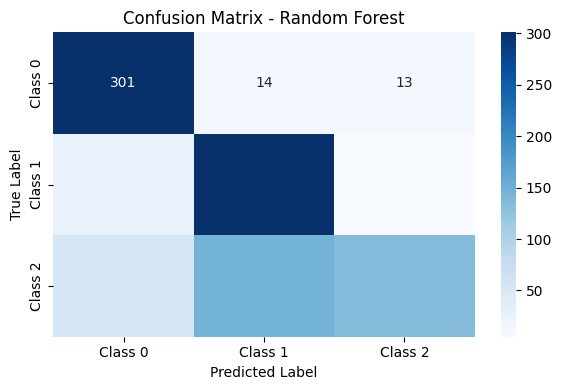

Evaluation metrics for SVM:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.327179  0.972561  0.489639  0.327179
1          1.0   0.500000  0.027190  0.051576  0.500000
2          2.0   0.000000  0.000000  0.000000  0.000000
average    NaN   0.274738  0.330312  0.178926  0.275726

[[319   9   0]
 [322   9   0]
 [334   0   0]]


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


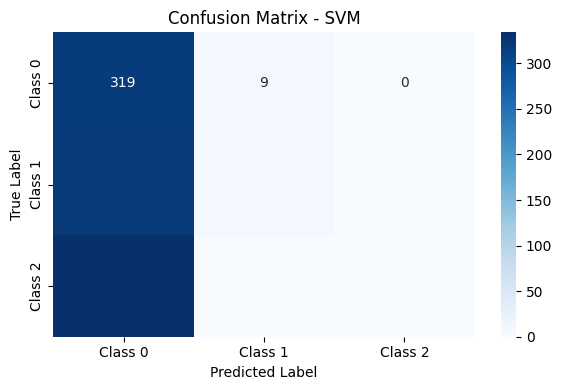

Evaluation metrics for LDA:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.317221  0.320122  0.318665  0.317221
1          1.0   0.283721  0.368580  0.320631  0.283721
2          2.0   0.056034  0.038922  0.045936  0.056034
average    NaN   0.218203  0.241692  0.227587  0.218992

[[105 117 106]
 [ 96 122 113]
 [130 191  13]]


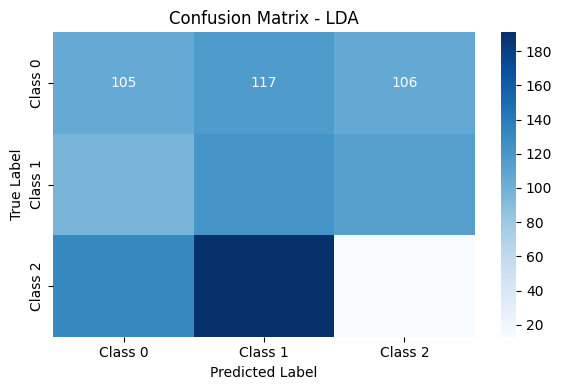

Evaluation metrics for KNN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.000000  0.000000  0.000000  0.000000
1          1.0   0.332661  0.996979  0.498866  0.332661
2          2.0   0.000000  0.000000  0.000000  0.000000
average    NaN   0.110887  0.332326  0.166289  0.110887

[[  0 328   0]
 [  1 330   0]
 [  0 334   0]]


C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Toey\AppData\Roaming\Python\Python311\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


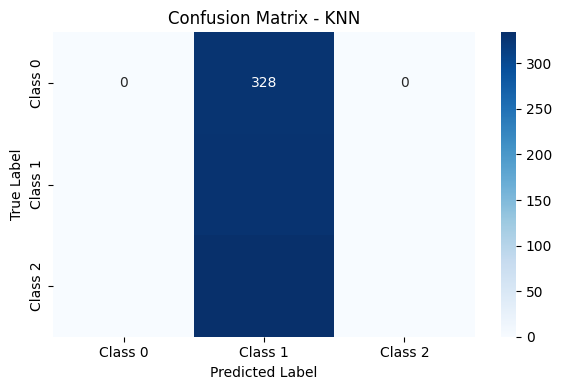

In [54]:
# Define the models and their predictions
models = ['Random Forest', 'SVM', 'LDA', 'KNN']
y_preds = [y_pred_rf_test, y_pred_svm_test, y_pred_lda_test, y_pred_knn_test]

for model, y_pred in zip(models, y_preds):
    # Calculate precision, recall, F1-score, and accuracy per class
    precision_per_class = precision_score(labels_test, y_pred, average=None)
    recall_per_class = recall_score(labels_test, y_pred, average=None)
    f1_per_class = f1_score(labels_test, y_pred, average=None)

    # Calculate accuracy per class
    accuracy_per_class = []
    for class_label in range(len(precision_per_class)):
        correct_predictions = ((y_pred == class_label) & (labels_test == class_label)).sum()
        total_predictions = (y_pred == class_label).sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_per_class.append(accuracy)

    # Calculate average precision, recall, F1-score, and accuracy
    avg_precision = precision_score(labels_test, y_pred, average='weighted')
    avg_recall = recall_score(labels_test, y_pred, average='weighted')
    avg_f1 = f1_score(labels_test, y_pred, average='weighted')

    # Create DataFrame for per-class metrics
    results_per_class_df = pd.DataFrame({
        'Class': range(len(precision_per_class)),
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Accuracy': accuracy_per_class
    })

    # Add average metrics to the DataFrame
    results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, np.mean(accuracy_per_class)]

    print(f"Evaluation metrics for {model}:")
    print(results_per_class_df)
    print()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.tight_layout()
    plt.show()

In [55]:
ann_model = load_model("model_FFT/ann_model_youtube.h5")
cnn_model = load_model("model_FFT/cnn_model_youtube.h5")
lstm_model = load_model("model_FFT/lstm_model_youtube.h5")
cnn_scaler = load("model_FFT/cnn_scaler_youtube.pkl")
lstm_scaler = load("model_FFT/lstm_scaler_youtube.pkl")

In [56]:
# Normalize data with Scaler
combined_test_scaled_cnn = cnn_scaler.transform(combined_test)
combined_test_scaled_lstm = lstm_scaler.transform(combined_test)
# Adapt data to the format used with the CNN model.
combined_test_reshaped_cnn = combined_test_scaled_cnn.reshape(-1, 363, 1)
# Predict with ANN
y_pred_ann = np.argmax(ann_model.predict(combined_test), axis=1)
# Predict with CNN
y_pred_cnn = np.argmax(cnn_model.predict(combined_test_reshaped_cnn), axis=1)
# Predict with LSTM
combined_test_reshaped_lstm = combined_test_scaled_lstm.reshape(-1, 363, 1)
y_pred_lstm = np.argmax(lstm_model.predict(combined_test_reshaped_lstm), axis=1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 65ms/step


Evaluation metrics for ANN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.363224  0.975610  0.529363  0.363224
1          1.0   0.000000  0.000000  0.000000  0.000000
2          2.0   0.052632  0.002994  0.005666  0.052632
average    NaN   0.137680  0.323263  0.176761  0.138618

[[320   0   8]
 [321   0  10]
 [240  93   1]]


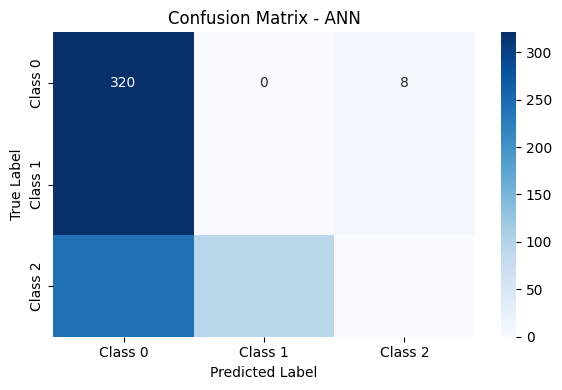

Evaluation metrics for CNN:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.200000  0.067073  0.100457  0.200000
1          1.0   0.483582  0.978852  0.647353  0.483582
2          2.0   0.990610  0.631737  0.771481  0.990610
average    NaN   0.560453  0.560926  0.508457  0.558064

[[ 22 305   1]
 [  6 324   1]
 [ 82  41 211]]


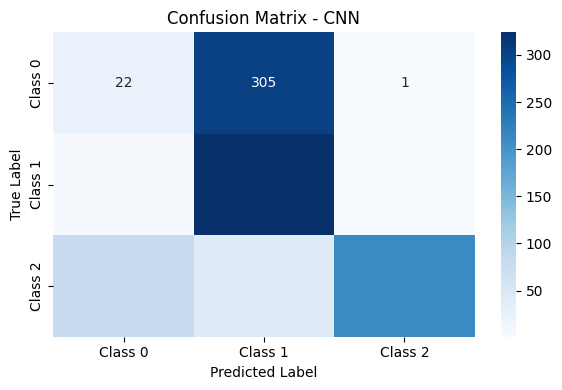

Evaluation metrics for LSTM:
         Class  Precision    Recall  F1-score  Accuracy
0          0.0   0.514760  0.850610  0.641379  0.514760
1          1.0   0.667969  0.516616  0.582624  0.667969
2          2.0   1.000000  0.583832  0.737240  1.000000
average    NaN   0.729042  0.649547  0.654037  0.727576

[[279  49   0]
 [160 171   0]
 [103  36 195]]


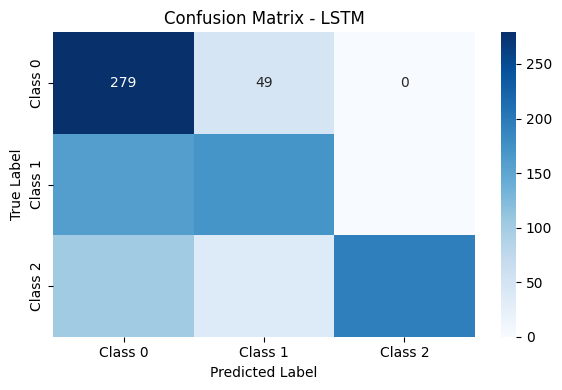

In [57]:
# Define the models and their predictions
models = ['ANN', 'CNN', 'LSTM']
y_preds = [y_pred_ann, y_pred_cnn, y_pred_lstm]

for model, y_pred in zip(models, y_preds):
    # Calculate precision, recall, F1-score, and accuracy per class
    precision_per_class = precision_score(labels_test, y_pred, average=None)
    recall_per_class = recall_score(labels_test, y_pred, average=None)
    f1_per_class = f1_score(labels_test, y_pred, average=None)

    # Calculate accuracy per class
    accuracy_per_class = []
    for class_label in range(len(precision_per_class)):
        correct_predictions = ((y_pred == class_label) & (labels_test == class_label)).sum()
        total_predictions = (y_pred == class_label).sum()
        accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
        accuracy_per_class.append(accuracy)

    # Calculate average precision, recall, F1-score, and accuracy
    avg_precision = precision_score(labels_test, y_pred, average='weighted')
    avg_recall = recall_score(labels_test, y_pred, average='weighted')
    avg_f1 = f1_score(labels_test, y_pred, average='weighted')

    # Create DataFrame for per-class metrics
    results_per_class_df = pd.DataFrame({
        'Class': range(len(precision_per_class)),
        'Precision': precision_per_class,
        'Recall': recall_per_class,
        'F1-score': f1_per_class,
        'Accuracy': accuracy_per_class
    })

    # Add average metrics to the DataFrame
    results_per_class_df.loc['average'] = [None, avg_precision, avg_recall, avg_f1, np.mean(accuracy_per_class)]

    print(f"Evaluation metrics for {model}:")
    print(results_per_class_df)
    print()

    # Plot confusion matrix
    cm = confusion_matrix(labels_test, y_pred)
    print(cm)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {model}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.yticks(ticks=[0.5, 1.5, 2.5], labels=['Class 0', 'Class 1', 'Class 2'])
    plt.tight_layout()
    plt.show()
